In [1]:
pip install mlflow seaborn matplotlib transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade typing_extensions pydantic pydantic-core

Note: you may need to restart the kernel to use updated packages.


In [4]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
print(f"PyTorch Version: {torch.__version__}")

# Import Transformers and MLflow
import mlflow
from transformers import pipeline

# Check Data
try:
    df = pd.read_parquet("../data/gold_reviews.parquet")
    print(f"Data Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: Could not find data/gold_reviews.parquet. Check your path!")

# Define Labels
LABELS = [
    "Quality & Effectiveness", 
    "Scent & Texture", 
    "Price & Value", 
    "Packaging & Shipping", 
    "Safety & Authenticity", 
    "Service"
]

PyTorch Version: 2.5.1+cpu
Data Loaded. Shape: (701528, 14)


In [5]:
def run_mlops_experiment(model_name, run_name, sample_texts):
    """
    Runs a model, measures speed, and logs metrics to MLflow.
    """
    # Set our tracking experiment name
    mlflow.set_experiment("Zero-Shot-Latency-Benchmark")
    
    with mlflow.start_run(run_name=run_name):
        print(f"\nStarting Run: {run_name}")
        print(f"Model: {model_name}")
        
        # Log Parameters
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("n_labels", len(LABELS))
        mlflow.log_param("sample_size", len(sample_texts))
        
        # Load Model
        device = 0 if torch.cuda.is_available() else -1
        device_name = "GPU" if device == 0 else "CPU"
        print(f"   -> Device: {device_name}")
        mlflow.log_param("device", device_name)
        
        pipe = pipeline("zero-shot-classification", model=model_name, device=device)
        
        # Run Inference & Measure Latency
        start_time = time.time()
        
        # The actual prediction loop
        results = pipe(sample_texts, candidate_labels=LABELS, multi_label=True)        
        
        end_time = time.time()
        
        # Calculate Metrics
        total_time = end_time - start_time
        avg_latency = (total_time / len(sample_texts)) * 1000 # in ms
        throughput = len(sample_texts) / total_time # reviews per second
        
        print(f"Total Time: {total_time:.2f}s")
        print(f"Avg Latency: {avg_latency:.2f} ms/review")
        
        # Log Metrics to MLflow (The Evidence)
        mlflow.log_metric("avg_latency_ms", avg_latency)
        mlflow.log_metric("throughput_rps", throughput)
        
        return avg_latency, results

sample_reviews = df[df['text'].str.len() > 50]['text'].sample(50, random_state=42).tolist()
print(f"Prepared {len(sample_reviews)} sample reviews for testing.")

Prepared 50 sample reviews for testing.


In [6]:
# Big Model
latency_a, results_a = run_mlops_experiment(
    model_name="facebook/bart-large-mnli", 
    run_name="Baseline_Large_Model", 
    sample_texts=sample_reviews
)

# Peek at a result
print(f"\nExample Prediction (Large Model):")
print(f"Text: {sample_reviews[0][:100]}...")

labels = results_a[0]['labels']
scores = results_a[0]['scores']
sorted_results = sorted(zip(labels, scores), key=lambda x: x[1], reverse=True)

for label, score in sorted_results:
    print(f"  - {label}: {score:.4f} ({score*100:.1f}%)")

c:\Users\Eda\anaconda3\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/22 21:09:57 INFO mlflow.tracking.fluent: Experiment with name 'Zero-Shot-Latency-Benchmark' does not exist. Creating a new experiment.



Starting Run: Baseline_Large_Model
Model: facebook/bart-large-mnli
   -> Device: CPU


c:\Users\Eda\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Total Time: 90.82s
Avg Latency: 1816.34 ms/review

Example Prediction (Large Model):
Text: The fibers fell off of my lashes and into my eyes and on my checks making a real mess....
  - Quality & Effectiveness: 0.3192 (31.9%)
  - Scent & Texture: 0.2175 (21.7%)
  - Safety & Authenticity: 0.1211 (12.1%)
  - Service: 0.1012 (10.1%)
  - Price & Value: 0.0850 (8.5%)
  - Packaging & Shipping: 0.0251 (2.5%)


In [7]:
# Small Model
latency_b, results_b = run_mlops_experiment(
    model_name="valhalla/distilbart-mnli-12-3", 
    run_name="Challenger_Distil_Model", 
    sample_texts=sample_reviews
)

# Peek at a result
print(f"\nExample Prediction (Small Model):")
print(f"Text: {sample_reviews[0][:100]}...")

labels = results_b[0]['labels']
scores = results_b[0]['scores']
sorted_results = sorted(zip(labels, scores), key=lambda x: x[1], reverse=True)

for label, score in sorted_results:
    print(f"  - {label}: {score:.4f} ({score*100:.1f}%)")


Starting Run: Challenger_Distil_Model
Model: valhalla/distilbart-mnli-12-3
   -> Device: CPU
Total Time: 52.90s
Avg Latency: 1057.97 ms/review

Example Prediction (Small Model):
Text: The fibers fell off of my lashes and into my eyes and on my checks making a real mess....
  - Quality & Effectiveness: 0.1290 (12.9%)
  - Safety & Authenticity: 0.0877 (8.8%)
  - Service: 0.0756 (7.6%)
  - Scent & Texture: 0.0574 (5.7%)
  - Price & Value: 0.0394 (3.9%)
  - Packaging & Shipping: 0.0089 (0.9%)


In [8]:
model_name_c = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"

latency_c, results_c = run_mlops_experiment(
    model_name=model_name_c, 
    run_name="SOTA_DeBERTa_Model", 
    sample_texts=sample_reviews
)

print(f"Example Prediction (DeBERTa):")
print(f"Text: {sample_reviews[0][:100]}...")

labels = results_c[0]['labels']
scores = results_c[0]['scores']
sorted_results = sorted(zip(labels, scores), key=lambda x: x[1], reverse=True)

print("DeBERTa Confidence Scores:")
for label, score in sorted_results:
    print(f"  - {label}: {score:.4f} ({score*100:.1f}%)")


Starting Run: SOTA_DeBERTa_Model
Model: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli
   -> Device: CPU


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Total Time: 49.12s
Avg Latency: 982.31 ms/review
Example Prediction (DeBERTa):
Text: The fibers fell off of my lashes and into my eyes and on my checks making a real mess....
DeBERTa Confidence Scores:
  - Scent & Texture: 0.4388 (43.9%)
  - Service: 0.2085 (20.9%)
  - Quality & Effectiveness: 0.0788 (7.9%)
  - Safety & Authenticity: 0.0787 (7.9%)
  - Price & Value: 0.0024 (0.2%)
  - Packaging & Shipping: 0.0012 (0.1%)


Text(0.5, 0.02, 'FINAL DECISION: DeBERTa is 1.8x Faster than Baseline!')

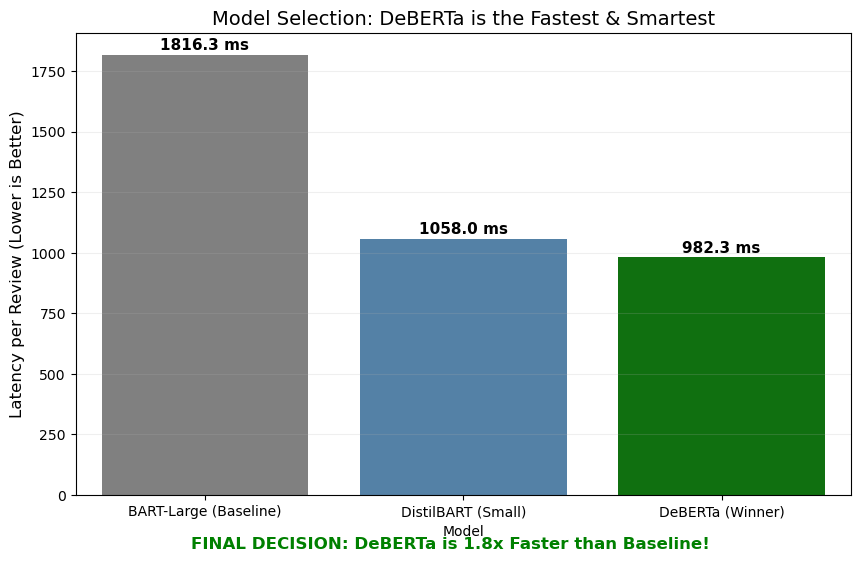

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["BART-Large (Baseline)", "DistilBART (Small)", "DeBERTa (Winner)"],
    "Latency (ms)": [latency_a, latency_b, latency_c]
})

plt.figure(figsize=(10, 6))

custom_palette = ["gray", "steelblue", "green"]

ax = sns.barplot(x="Model", y="Latency (ms)", data=comparison_df, palette=custom_palette)

for i, v in enumerate(comparison_df["Latency (ms)"]):
    ax.text(i, v + 20, f"{v:.1f} ms", ha='center', fontweight='bold', fontsize=11)

plt.title("Model Selection: DeBERTa is the Fastest & Smartest", fontsize=14)
plt.ylabel("Latency per Review (Lower is Better)", fontsize=12)
plt.grid(axis='y', alpha=0.2)

# Calculate Speedup (DeBERTa vs Baseline)
speedup = latency_a / latency_c
plt.figtext(0.5, 0.02, f"FINAL DECISION: DeBERTa is {speedup:.1f}x Faster than Baseline!", 
            ha="center", fontsize=12, color="green", weight="bold")



c:\Users\Eda\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


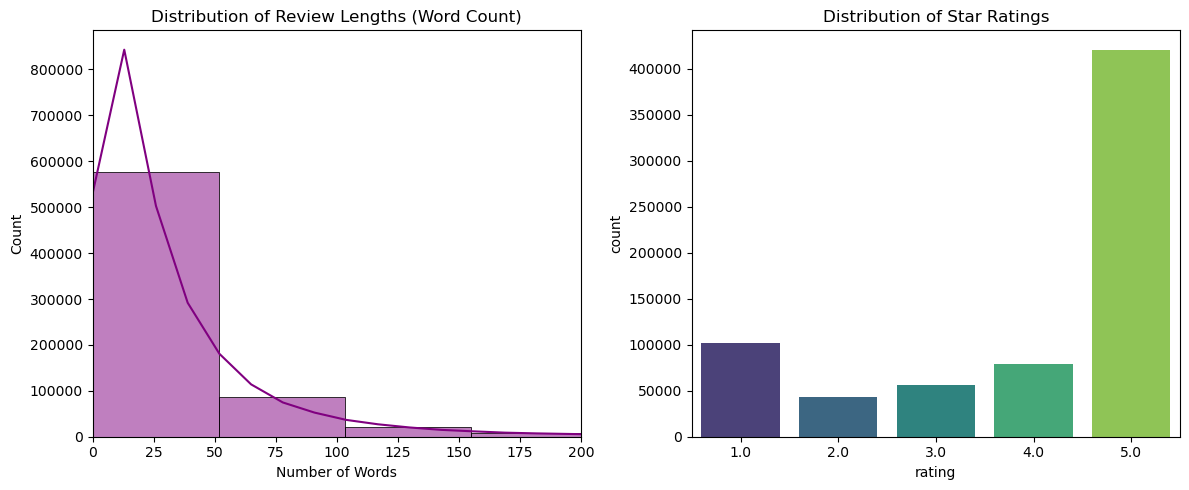

Average Review Length: 32.8 words
Data is concise. Good for Real-Time inference.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=50, kde=True, color='purple')
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.xlim(0, 200)

plt.subplot(1, 2, 2)
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Distribution of Star Ratings")

plt.tight_layout()
plt.show()

avg_len = df['word_count'].mean()
print(f"Average Review Length: {avg_len:.1f} words")
if avg_len > 100:
    print("Warning: Data is verbose. Latency will be higher.")
else:
    print("Data is concise. Good for Real-Time inference.")

In [11]:
# Final "Stress Test" on the Winning Model
# We increase sample size to 200 for statistical significance
stress_sample = df['text'].sample(200, random_state=42).tolist()

print(f"Starting Stress Test on {len(stress_sample)} reviews with DeBERTa...")

latency_final, results_final = run_mlops_experiment(
    model_name="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", 
    run_name="Final_Stress_Test_DeBERTa", 
    sample_texts=stress_sample
)

print(f"Official Latency (N=200): {latency_final:.2f} ms/review")

Starting Stress Test on 200 reviews with DeBERTa...

Starting Run: Final_Stress_Test_DeBERTa
Model: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli
   -> Device: CPU


c:\Users\Eda\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Total Time: 196.76s
Avg Latency: 983.78 ms/review
Official Latency (N=200): 983.78 ms/review


In [12]:
import pandas as pd

# Grab 5 random results from the stress test
examples = []

for i in range(5):
    text = stress_sample[i]
    # Get the scores/labels
    labs = results_final[i]['labels']
    scrs = results_final[i]['scores']
    
    # Combine them
    top_3 = sorted(zip(labs, scrs), key=lambda x: x[1], reverse=True)[:3]
    
    # Format for display
    top_3_str = ", ".join([f"{l} ({s:.2f})" for l, s in top_3])
    examples.append({"Review": text[:80] + "...", "Model's Top 3": top_3_str})

# Show as a clean table
pd.set_option('display.max_colwidth', None)
display(pd.DataFrame(examples))

,Review,Model's Top 3
0,"Me encanto, es más bonita de lo que espere me gustaría encontrar algo más clara ...","Service (0.75), Quality & Effectiveness (0.72), Scent & Texture (0.38)"
1,"The eyelash curler has some sharp edges (not enough to cut you probably, but it'...","Quality & Effectiveness (0.82), Service (0.09), Safety & Authenticity (0.06)"
2,This has been my wife's favorite bath powder for years. I also enjoy the fragran...,"Quality & Effectiveness (0.95), Service (0.94), Scent & Texture (0.73)"
3,Loved this color it is absolutely beautiful. Perfect for fall. Lasts long...,"Quality & Effectiveness (0.91), Safety & Authenticity (0.07), Scent & Texture (0.02)"
4,Leaves hair really soft...,"Quality & Effectiveness (0.91), Service (0.84), Safety & Authenticity (0.48)"
